<a href="https://colab.research.google.com/github/Congliu0829/cencus_dnn_caching/blob/master/Adult_census_use_cluster_k_%3D_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append('/content/adult.csv')
from utils import * 
from model_embedding import *


In [ ]:
import matplotlib.pyplot as plt
def plot_acc_fairness(model):
    f, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2, sharex=True, sharey=False)
    curr_ax = axes[0]
    curr_ax.plot( [x[0] for x in model.logs])
    curr_ax.set_ylabel('Model Accuracy', fontsize = 20)
    curr_ax.set_xlabel('Epochs', fontsize = 20)
    curr_ax.tick_params(axis="x", labelsize=15) 
    plt.show()
    
    

In [ ]:
from utils import * 
from normalize import *
pd00, label_name, feats = load_data('census')
seed = 0
X_train, X_val, X_test, y_train, y_val, y_test= get_data_loader(pd00, feats, label_name,seed=seed)

params = {}
kfold_n_splits = 10
index = 9 #used for change experiment index
kf = KFold(n_splits=kfold_n_splits)
X = pd00[feats].values
y = pd00[label_name].values
X_train_all = []
X_test_all = []
y_train_all = []
y_test_all = []

for train_index, test_index in kf.split(X):
  X_train_kfold, X_test_kfold = X[train_index], X[test_index]
  X_train_all.append(X_train_kfold)
  X_test_all.append(X_test_kfold)
  y_train_kfold, y_test_kfold = y[train_index], y[test_index]
  y_train_all.append(y_train_kfold)
  y_test_all.append(y_test_kfold)

X_train_all = normalize(X_train_all)
X_test_all = normalize(X_test_all)

  
X_train_kfold_all = X_train_all 
X_test_kfold_all = X_test_all
y_train_kfold_all = y_train_all
y_test_kfold_all = y_test_all

params['X_train'] = X_train_kfold_all[index]
params['X_val'] = X_test_kfold_all[index]
params['y_train'] = y_train_kfold_all[index]
params['y_val'] = y_test_kfold_all[index]
params['device'] = 'cpu'
params['bs'] = 256
params['epoches'] = 100
options = {}
options['model_lr'] = 1e-3

options['epochs'] = 400
input_dim = X_train_kfold_all[index].shape[1]
options['input_size'] = input_dim





In [ ]:
len(X_train_kfold_all[0])

27145

In [ ]:
## GRID SEARCH TO SELECT OPTIMAL NETWORK STRUCTURE
grid_search_list = []
options['acc_only'] = True #  Accuracy as the Metric to select Optimal Network  
options['step_size'] = 0.0 # Disable step-size if you only need to learn a simple classifier (w.o fairness)
options['lr_mult'] = 0  # also need to set the initial Multipliers to be zeroes

for n_gen in [int(x) for x in np.linspace(input_dim / 2, input_dim - 1, 2)]:
    for n_z in [int(x) for x in np.linspace(input_dim / 5 + 1, input_dim / 2, 2)]:
        if n_z < n_gen:
            curr_options = copy.deepcopy(options)
            curr_options['model_params'] = {'input_size': input_dim, 'gen_nnodes_list': [n_gen],
                                            'z1_nnodes_list': [n_z], \
                                            'z0_nnodes_list': [n_z]}
            grid_search_list.append(curr_options)

### 1. A simple Deep Network Classifier

In [ ]:
# A simple deep network classifier without fairness
mc_model = LDSharedModel(params)
mc_model.hyper_opt(grid_search_list)

{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [6], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}}
{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [11], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}}
{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [11], 'z1_nnodes_list': [6], 'z0_nnodes_list': [6]}}


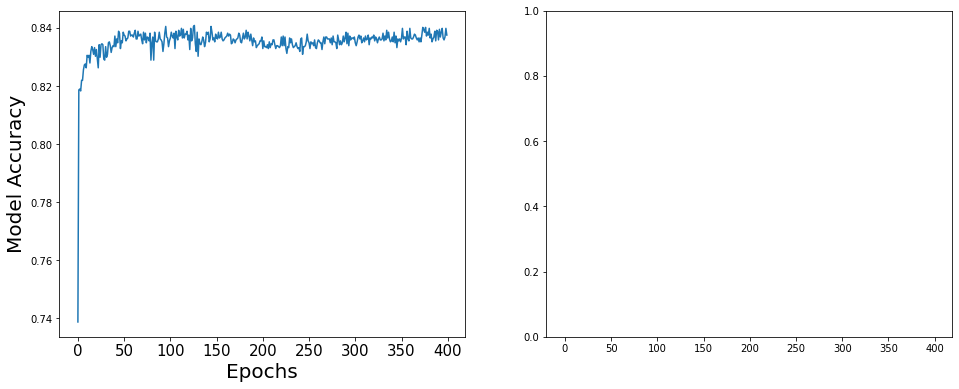

In [ ]:
plot_acc_fairness(mc_model)

In [ ]:
best_options = mc_model.best_options
print(best_options)

{'model_lr': 0.001, 'epochs': 400, 'input_size': 12, 'acc_only': True, 'step_size': 0.0, 'lr_mult': 0, 'model_params': {'input_size': 12, 'gen_nnodes_list': [6], 'z1_nnodes_list': [3], 'z0_nnodes_list': [3]}, 'return_output': True}


In [ ]:
mc_model._model_eval(mc_model)

0.8375331564986738



###2.   Use best_option to train Basic Net



In [ ]:
from cache import *
cache = Cache(2) # we'll use only the hidden layers


In [ ]:
train_tensor = TensorDataset(Tensor(params['X_train']), Tensor(params['y_train']))
train_loader = DataLoader(dataset = train_tensor, batch_size = params['bs'], shuffle = True)

In [ ]:
for epoch in range(params['epoches']):
  for (x, y) in train_loader:
    # for (x, y) in data:
        (x, y) = x.to(params['device']), y.to(params['device'])
        h1 = mc_model.get_embedding(x, 1) 
        cache.store(h1, 1)

        h2 = mc_model.get_embedding(x, 2) 
        cache.store(h2, 2)
        cache.store_label(y)

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from torch_utils import *
from dataset import Dataset
from basicnet import Net
import matplotlib.pyplot as plt
from cache import Cache

In [ ]:
from autoencoder import AutoEncoder
ae1 = AutoEncoder(10, 2)
ae2 = AutoEncoder(5, 2)

ae_loss1 = nn.MSELoss()
ae_loss2 = nn.MSELoss()
opt1 = optim.Adam(ae1.parameters(), lr=0.001)
opt2 = optim.Adam(ae2.parameters(), lr=0.001)

y1_loss=[]
y2_loss=[]

for epoch in range(5):#params['epochs']):
    for x1 in cache.embeddings[1]:
        opt1.zero_grad()
        x̃1 = ae1(x1)
        l1 = ae_loss1(x̃1, x1)
        l1.backward(retain_graph=True)
        opt1.step() 
        y1_loss.append(l1.item())
    
    for x2 in cache.embeddings[2]:
        opt2.zero_grad()
        x̃2 = ae2(x2)
        l2 = ae_loss2(x̃2, x2)
        l2.backward(retain_graph=True)
        opt2.step()
        y2_loss.append(l2.item())


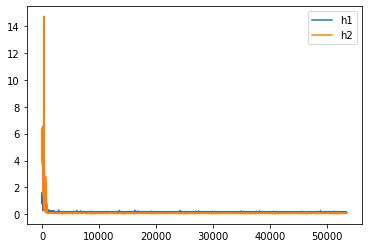

In [ ]:
plt.plot(y1_loss)
plt.plot(y2_loss)
plt.legend(['h1', 'h2'])



###3.   (Test) Split cache, find clusters, find neighbors



In [ ]:
cache_train = Cache(2)
for (x, y) in train_loader:
  (x, y) = x.to(params['device']), y.to(params['device'])
  h_t1 = mc_model.get_embedding(x, 1)
  cache_train.store(h_t1, 1)
  h_t2 = mc_model.get_embedding(x, 2) 
  cache_train.store(h_t2, 2)
  cache_train.store_label(y)

In [ ]:
#This aims to split tensors so that batchsize will be equal to 1
from split import *
split_1 = split(cache_train.embeddings[1])
split_2 = split(cache_train.embeddings[2])
split_labels = split(cache_train.labels)

In [ ]:
len(split_1)

27146

In [ ]:
'''This aims to store the first and second element of the output tensor, in order to construct bins'''
'''a1 b1 represent the first and second element of the output from layer1'''
'''so as to a2 b2'''
def convert(tensor_from_layer1, tensor_from_layer2, tensor_labels):
	'''This function aims to convert tensors to list (single data points)'''
	a1 = []
	a2 = []
	b1 = []
	b2 = []
	all_lst1 = []
	all_lst2 = []
	each_label = []
	for tensor1 in tensor_from_layer1:
		x_out1 = ae1.encode(tensor1)
		a1.append(x_out1.detach().numpy()[0][0])
		b1.append(x_out1.detach().numpy()[0][1])
		all_lst1.append([x_out1.detach().numpy()[0][0], x_out1.detach().numpy()[0][1]])
	
	for tensor2 in tensor_from_layer2:
		x_out2 = ae2.encode(tensor2)
		a2.append(x_out2.detach().numpy()[0][0])
		b2.append(x_out2.detach().numpy()[0][1])
		all_lst2.append([x_out2.detach().numpy()[0][0], x_out2.detach().numpy()[0][1]])

	for tensor_l in tensor_labels:
		each_label.append(tensor_l.numpy()[0])

	return a1, b1, all_lst1, a2, b2, all_lst2, each_label




In [ ]:
#This aims to store the first and second element of the output tensor, in order to construct bins
'''
a1 b1 represent the first and second element of the output from layer1
so as to a2 b2
'''
a1, b1, freeze_layer1, a2, b2, freeze_layer2, each_label = convert(split_1, split_2, split_labels)

In [ ]:
#seperate elements from output of layers with respect to their labels
#a1_0 represents for first element in layer1 with label 0
#b2_1 represents for second element in layer2 with label 1
import numpy as np
a1_0 = []
b1_0 = []
a2_0 = []
b2_0 = []
a1_1 = []
a2_1 = []
b1_1 = []
b2_1 = []
freeze_layer1_label0 = []
freeze_layer1_label1 = []
freeze_layer2_label0 = []
freeze_layer2_label1 = []
for i in range(len(each_label)):
  if each_label[i] == 0:
    a1_0.append(a1[i])
    b1_0.append(b1[i])
    a2_0.append(a2[i])
    b2_0.append(b2[i])
    freeze_layer1_label0.append(freeze_layer1[i])
    freeze_layer2_label0.append(freeze_layer2[i])
  if each_label[i] == 1:
    a1_1.append(a1[i])
    b1_1.append(b1[i])
    a2_1.append(a2[i])
    b2_1.append(b2[i])
    freeze_layer1_label1.append(freeze_layer1[i])
    freeze_layer2_label1.append(freeze_layer2[i])

###Histogram

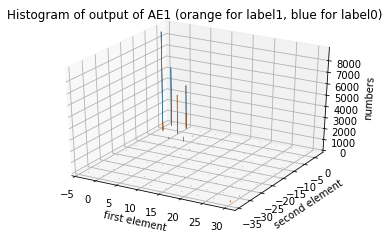

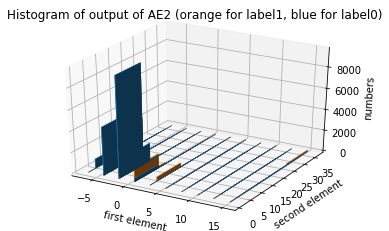

In [ ]:
''' Plot the 3d histograms of output from 2 layers with respect to their first
 and second element and their corresponding labels'''

from histogram_3d_both import *
plot_his_3d_both(a1_0, b1_0, a1_1, b1_1, 0.1, 0.1, a1, b1, 'Histogram of output of AE1 (orange for label1, blue for label0)')
plot_his_3d_both(a2_0, b2_0, a2_1, b2_1, 0.1, 10, a2, b2, 'Histogram of output of AE2 (orange for label1, blue for label0)')

In [ ]:
a2_0

[-0.15394181,
 -0.80185854,
 -0.53362215,
 -0.09113097,
 -1.2900145,
 -0.92239296,
 -2.8053238,
 -0.013409909,
 -0.48215222,
 -0.7738842,
 -1.7580135,
 -1.1068977,
 -0.8724731,
 -0.476444,
 -2.6222575,
 -2.3197415,
 -1.7366271,
 -0.060036894,
 -2.3540537,
 -2.0143695,
 -0.015654203,
 -1.2017697,
 -0.058818277,
 -1.5897564,
 -0.54229665,
 -0.7034832,
 -1.3706882,
 -1.4156201,
 -0.91696584,
 0.18932825,
 -1.4244082,
 -1.1667198,
 -0.05636519,
 -0.109945655,
 -0.21941113,
 -1.9107227,
 -1.8606129,
 -0.81000847,
 -1.103968,
 -0.41208446,
 -3.16956,
 -3.038043,
 -0.39983416,
 0.7967905,
 -1.3057916,
 -0.5497502,
 -1.8155645,
 -1.2095319,
 -2.5193257,
 -2.0421872,
 -0.584168,
 -0.044124838,
 -1.5682876,
 -0.87250257,
 -1.5630271,
 -1.4336183,
 0.77125466,
 -0.6283767,
 -1.8574258,
 -2.3814988,
 -3.3636696,
 -3.021192,
 -0.77474046,
 -2.5870328,
 0.015586499,
 -1.4767866,
 -1.4682442,
 -1.0018976,
 -1.457412,
 -2.956862,
 -1.0550276,
 -0.93746376,
 -2.184593,
 -0.67457265,
 -2.7372754,
 -2.89

In [ ]:
# #This aims to check the distribution of the data which is in highest bar in AE1 of AE2.'''
# #Take out the index of data in highest bar in AE1 and use index to take out corresponding data in AE2'''

# from replot_highest import *
# row1, row2 = replot_highest(a1_0, b1_0, a2_0, b2_0)
# row3, row4 = replot_highest(a1_1, b1_1, a2_1, b2_1)

# #Replot data extracted above in AE2 plot'''
# from histogram_3d import *
# plot_his_3d(row1, row2, 0.000001, 0.0001, a2_0, b2_0, 'histogram of data in highest bar in AE1 plotted in AE2 (label0)')
# plot_his_3d(a2_0, b2_0, 0.000001, 0.0001, a2_0, b2_0, 'Original histogram of AE2 (label0)')
# plot_his_3d(row3, row4, 0.000001, 0.0001, a2_1, b2_1, 'histogram of data in highest bar in AE1 plotted in AE2 (label1)')
# plot_his_3d(a2_1, b2_1, 0.000001, 0.0001, a2_1, b2_1, 'Original histogram of AE2 (label1)')

In [ ]:
len(each_label)

27146

###Test training


In [ ]:
test_tensor = TensorDataset(Tensor(params['X_val']), Tensor(params['y_val']))
test_loader = DataLoader(dataset = test_tensor, batch_size = params['bs'], shuffle = True)

In [ ]:
#derive the testing set data, train it and store the output from the basicnet.
cache_test = Cache(2)
for (x, y) in test_loader:
  (x, y) = x.to(params['device']), y.to(params['device'])  
  h1_test = mc_model.get_embedding(x, 1) 
  cache_test.store(h1_test, 1)

  h2_test = mc_model.get_embedding(x, 2) 
  cache_test.store(h2_test, 2)
  cache_test.store_label(y)



In [ ]:
#split test data so that each data points can be used
split1_test = split(cache_test.embeddings[1])
split2_test = split(cache_test.embeddings[2])
split_labels_test = split(cache_test.labels)

In [ ]:
# 'derive the output from AE'
# layer_num = 1
# layer_test = layer1_test
# for i in range(len(layer_test)):
# 	if layer_num == 1:
# 		layer_test[i] = ae1.encode(layer_test[i])
# 	if layer_num == 2:
# 		layer_test[i] = ae2.encode(layer_test[i])

In [ ]:
#convert the data to list which is used to compute epsilon of knn
a1_test, b1_test, freeze_layer1_test, a2_test, b2_test, freeze_layer2_test, labels_test = convert(split1_test, split2_test, split_labels_test)

### Plot test set

In [ ]:
#seperate elements from output of layers with respect to their labels
#a1_0 represents for first element in layer1 with label 0
#b2_1 represents for second element in layer2 with label 1
import numpy as np
a1_t_0 = []
b1_t_0 = []
a2_t_0 = []
b2_t_0 = []
a1_t_1 = []
a2_t_1 = []
b1_t_1 = []
b2_t_1 = []
test_freeze_layer1_label0 = []
test_freeze_layer1_label1 = []
test_freeze_layer2_label0 = []
test_freeze_layer2_label1 = []
for i in range(len(labels_test)):
  if labels_test[i] == 0:
    a1_t_0.append(a1_test[i])
    b1_t_0.append(b1_test[i])
    a2_t_0.append(a2_test[i])
    b2_t_0.append(b2_test[i])
    test_freeze_layer1_label0.append(freeze_layer1_test[i])
    test_freeze_layer2_label0.append(freeze_layer2_test[i])
  if labels_test[i] == 1:
    a1_t_1.append(a1_test[i])
    b1_t_1.append(b1_test[i])
    a2_t_1.append(a2_test[i])
    b2_t_1.append(b2_test[i])
    freeze_layer1_label1.append(freeze_layer1_test[i])
    freeze_layer2_label1.append(freeze_layer2_test[i])

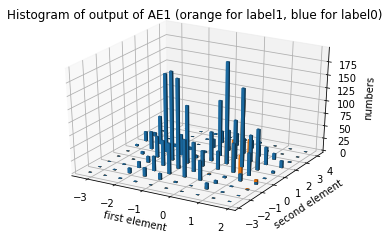

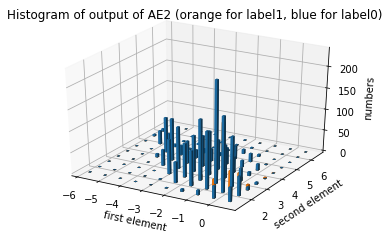

In [ ]:
''' Plot the 3d histograms of output from 2 test layers with respect to their first
 and second element and their corresponding labels'''

from histogram_3d_both import *
plot_his_3d_both(a1_t_0, b1_t_0, a1_t_1, b1_t_1, 0.1, 0.1, a1_test, b1_test, 'Histogram of output of AE1 (orange for label1, blue for label0)')
plot_his_3d_both(a2_t_0, b2_t_0, a2_t_1, b2_t_1, 0.1, 0.1, a2_test, b2_test, 'Histogram of output of AE2 (orange for label1, blue for label0)')

### Cluster

In [ ]:
from grid_cluster import *
# This aims to grid the data in caches and find centroids with corresponding confidence in each cluster
# Here we grid data by 2*2 matrix, for each grid, we have 4 clusters
confi_layer1_label0, cluster_layer1_label0 = grid_cluster(freeze_layer1_label0, a1_0, b1_0, 2, 4)
confi_layer1_label1, cluster_layer1_label1 = grid_cluster(freeze_layer1_label1, a1_1, b1_1, 2, 4)
# confi_layer2_label0, cluster_layer2_label0 = grid_cluster(freeze_layer2_label0, a2_0, b2_0, 10, 4)
# confi_layer2_label1, cluster_layer2_label1 = grid_cluster(freeze_layer2_label1, a2_1, b2_1, 10, 4)

In [ ]:
#combine centroids with label0 and with label1
confi_layer1 = confi_layer1_label0 + confi_layer1_label1
cluster_layer1 = cluster_layer1_label0 + cluster_layer1_label1
# confi_layer2 = confi_layer2_label0 + confi_layer2_label1
# cluster_layer2 = cluster_layer2_label0 + cluster_layer2_label1

In [ ]:
#seperate elements from output of layers with respect to their labels
#a1_0 represents for first element in layer1 with label 0
#b2_1 represents for second element in layer2 with label 1
import numpy as np
a1_c = [] 
b1_c = []
a1_c_0 = []
b1_c_0 = []

a1_c_1 = []
b1_c_1 = []

for i in range(len(confi_layer1_label0)):
  a1_c_0.append(cluster_layer1_label0[i][0])
  b1_c_0.append(cluster_layer1_label0[i][1])
for i in range(len(confi_layer1_label1)):
  a1_c_1.append(cluster_layer1_label1[i][0])
  b1_c_1.append(cluster_layer1_label1[i][1])

for i in range(len(confi_layer1)):
  a1_c.append(cluster_layer1[i][0])
  b1_c.append(cluster_layer1[i][1])



No handles with labels found to put in legend.


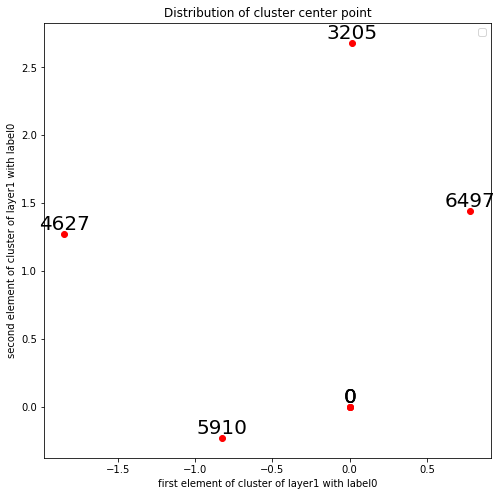

In [ ]:
# encoding=utf-8
import matplotlib.pyplot as plt
 
# 设置画布大小
plt.figure(figsize=(8, 8))
 
# 标题
plt.title("Distribution of cluster center point")
 
# 数据
plt.plot(a1_c_0, b1_c_0, 'ro')
 
# 横坐标描述
plt.xlabel('first element of cluster of layer1 with label0')
 
# 纵坐标描述
plt.ylabel('second element of cluster of layer1 with label0')
 
# 设置数字标签
for a, b, c in zip(a1_c_0, b1_c_0, confi_layer1_label0):
    plt.text(a, b, c, ha='center', va='bottom', fontsize=20)
 
plt.legend()
plt.show()

No handles with labels found to put in legend.


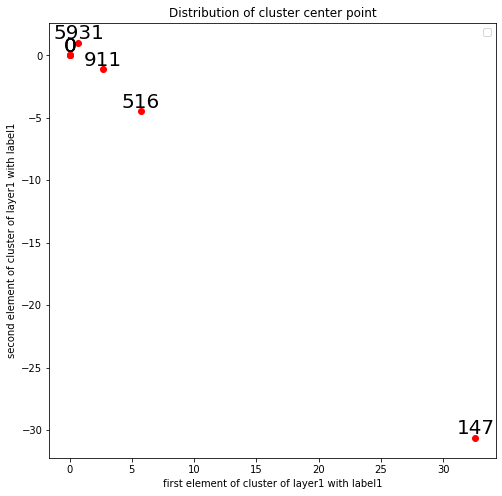

In [ ]:
# encoding=utf-8
import matplotlib.pyplot as plt
 
# 设置画布大小
plt.figure(figsize=(8, 8))
 
# 标题
plt.title("Distribution of cluster center point")
 
# 数据
plt.plot(a1_c_1, b1_c_1, 'ro')
 
# 横坐标描述
plt.xlabel('first element of cluster of layer1 with label1')
 
# 纵坐标描述
plt.ylabel('second element of cluster of layer1 with label1')
 
# 设置数字标签
for a, b, c in zip(a1_c_1, b1_c_1, confi_layer1_label1):
    plt.text(a, b, c, ha='center', va='bottom', fontsize=20)
 
plt.legend()
plt.show()

In [ ]:
#instead of use KNN, we use small number as enlarging radius of our data to capture the nearest clusters.
# we find data in centroid of layer in the range of a+- small number

#Here I only do neighboring in test layer1.
# Take all training data and all testing data points.
import time
from enlarging_radius_1 import *
acc_log = {i: [] for i in range(1,10)}
for threshold_coe in range(1,10):
  threshold = threshold_coe * 0.1 
  start = time.time()
  layer1_label_pred, neighbor = get_label(1, True, len(confi_layer1)/2, a1, b1, a2, b2, freeze_layer1_test, each_label, cluster_layer1, confi_layer1, 1000000, threshold)
  end = time.time()
  
  print(end - start)

  #calculate acc
  length = 0
  for i in neighbor.values():
    length += len(i)
  #calculate acc
  correct = 0
  miss = 0
  no_neighbor = 0
  error = 0
  for i in range(len(freeze_layer1_test)):
    if layer1_label_pred[i] == 'not sure':
      miss += 1
    elif layer1_label_pred[i] == 'do not have neighbor in this range':
      no_neighbor += 1
    elif int(layer1_label_pred[i]) == int(labels_test[i]):
      correct += 1
    elif int(layer1_label_pred[i]) + int(labels_test[i]) == 1:
      error += 1
  
  if (len(layer1_label_pred) - no_neighbor - miss) == 0:
    accuracy = 'All miss'
    cache_miss = miss/len(layer1_label_pred)
    no = no_neighbor/len(layer1_label_pred)
    error = 'None'
  else:
    accuracy = correct/(len(layer1_label_pred) - no_neighbor - miss)
    cache_miss = miss/len(layer1_label_pred)
    no = no_neighbor/len(layer1_label_pred)
    error = error/(len(layer1_label_pred) - no_neighbor - miss)

    
  
  
  



  #store in log
  acc_log[threshold_coe].append(['threshold:',threshold, 'average neighbors:', length/len(freeze_layer1_test),'process time:', end-start, 'acc:', accuracy, 'cache miss rate', cache_miss, 'error rate', error, 'no neighbor', no])

0.4504053592681885
0.5845389366149902
0.4440031051635742
0.44849157333374023
0.43971753120422363
0.580585241317749
0.44563984870910645
0.4440925121307373
0.5710093975067139


In [ ]:
acc_log

{1: [['threshold:',
   0.1,
   'average neighbors:',
   11.679376657824934,
   'process time:',
   0.4504053592681885,
   'acc:',
   0.8003978779840849,
   'cache miss rate',
   0.0,
   'error rate',
   0.19960212201591512,
   'no neighbor',
   0.0]],
 2: [['threshold:',
   0.2,
   'average neighbors:',
   11.679376657824934,
   'process time:',
   0.5845389366149902,
   'acc:',
   0.8003978779840849,
   'cache miss rate',
   0.0,
   'error rate',
   0.19960212201591512,
   'no neighbor',
   0.0]],
 3: [['threshold:',
   0.30000000000000004,
   'average neighbors:',
   11.679376657824934,
   'process time:',
   0.4440031051635742,
   'acc:',
   0.8003978779840849,
   'cache miss rate',
   0.0,
   'error rate',
   0.19960212201591512,
   'no neighbor',
   0.0]],
 4: [['threshold:',
   0.4,
   'average neighbors:',
   11.679376657824934,
   'process time:',
   0.44849157333374023,
   'acc:',
   0.8003978779840849,
   'cache miss rate',
   0.0,
   'error rate',
   0.19960212201591512,
   